In [1]:
# ---------------------------------------------------------------
# Copyright (c) 2022, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the NVIDIA Source Code License
# for Denoising Diffusion GAN. To view a copy of this license, see the LICENSE file.
# ---------------------------------------------------------------


import argparse
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy

import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchmetrics.image.fid import FrechetInceptionDistance

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision import datasets
from torch.utils.data import TensorDataset
from discrete_ot import OTPlanSampler


from torch.multiprocessing import Process
import torch.distributed as dist
import shutil
import pdb

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import wandb

from torch_ema import ExponentialMovingAverage
from torch.utils.data import DataLoader

from datetime import datetime
datetime_marker_str = datetime.now().strftime("%d:%m:%y_%H:%M:%S")

## Parameters

In [ ]:

fid_n_samples = 100
eps = 1

T = 4
exp_name = 'BMGAN_Cifar_downsample'
mini_batch_OT = False
plan = 'ind'

D_opt_steps = 2
ema_decay = 0.99

ipmf_iters = 20
markovian_proj_iters = 10000 #30000

inner_ipmf_mark_proj_iters = 2000 #10000

mini_batch_OT = 0

ema_start_ipmf = 0

device = 'cuda:0'


In [3]:
if mini_batch_OT > 0:
    mini_batch_OT = True
else:
    mini_batch_OT = False

if ema_start_ipmf > 0:
    ema_start_ipmf = True
else:
    ema_start_ipmf = False


In [4]:

config = {'eps': eps, 'T': T, 'mini_batch_OT': mini_batch_OT, 'D_opt_steps': D_opt_steps, 'ema_decay': ema_decay,
'ipmf_iters': ipmf_iters, 'markovian_proj_iters': markovian_proj_iters, 
'inner_ipmf_mark_proj_iters': inner_ipmf_mark_proj_iters, 'ema_start_ipmf': ema_start_ipmf, 'plan': plan}


In [5]:

def config_to_expdir(config):
    exp_dir = datetime_marker_str
    
    for key, value in config.items():
        exp_dir += str(key) + '=' + str(value) + '\\'
        
    return exp_dir

save_dir = config_to_expdir(config)

os.makedirs(os.path.join(exp_name, save_dir))


## Helper functions and posterior sampling

including p(x_t | x_0, x_1) from Brownian Bridge

In [6]:

# FID calculation
def normalize_tensor(tensor):
    normalized = tensor / 2 + 0.5
    return normalized.clamp_(0, 1)


def to_uint8_tensor(tensor):
    tensor = normalize_tensor(tensor)
    return tensor.mul(255).add_(0.5).clamp_(0, 255).to(torch.uint8)


def compute_fid_and_ot_cost(true_dataloader, model_input_dataloader, sample_fn):
    # backward loader y -> x
    ot_cost = 0
    fid = FrechetInceptionDistance().to(device)
    
    for item in iter(true_dataloader):
        x = item[0]
        fid.update(to_uint8_tensor(x.expand(-1, 3, -1, -1)).to(device), real=True)

    for item in iter(model_input_dataloader):
        y = item[0]
        fake_sample = sample_fn(y.to(device))
        fid.update(to_uint8_tensor(fake_sample.expand(-1, 3, -1, -1)), real=False)

        ot_cost += F.mse_loss(fake_sample.to(device), y.to(device)) * y.shape[0]

    ot_cost = ot_cost / 10000
        
    return fid.compute(), ot_cost
        

In [7]:

def copy_source(file, output_dir):
    shutil.copyfile(file, os.path.join(output_dir, os.path.basename(file)))
            
def broadcast_params(params):
    for param in params:
        dist.broadcast(param.data, src=0)


#%% Diffusion coefficients 
def var_func_vp(t, beta_min, beta_max):
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    var = 1. - torch.exp(2. * log_mean_coeff)
    return var

def var_func_geometric(t, beta_min, beta_max):
    return beta_min * ((beta_max / beta_min) ** t)

def extract(input, t, shape):
    out = torch.gather(input, 0, t)
    reshape = [shape[0]] + [1] * (len(shape) - 1)
    out = out.reshape(*reshape)

    return out

def get_time_schedule(args, device):
    n_timestep = args.num_timesteps
    eps_small = 1e-3
    t = np.arange(0, n_timestep + 1, dtype=np.float64)
    t = t / n_timestep
    t = torch.from_numpy(t) * (1. - eps_small)  + eps_small
    return t.to(device)

def get_sigma_schedule(args, device):
    n_timestep = args.num_timesteps
    beta_min = args.beta_min
    beta_max = args.beta_max
    eps_small = 1e-3
   
    t = np.arange(0, n_timestep + 1, dtype=np.float64)
    t = t / n_timestep
    t = torch.from_numpy(t) * (1. - eps_small) + eps_small
    
    if args.use_geometric:
        var = var_func_geometric(t, beta_min, beta_max)
    else:
        var = var_func_vp(t, beta_min, beta_max)
    alpha_bars = 1.0 - var
    betas = 1 - alpha_bars[1:] / alpha_bars[:-1]
    
    first = torch.tensor(1e-8)
    betas = torch.cat((first[None], betas)).to(device)
    betas = betas.type(torch.float32)
    sigmas = betas**0.5
    a_s = torch.sqrt(1-betas)
    return sigmas, a_s, betas

class Diffusion_Coefficients():
    def __init__(self, args, device):
                
        self.sigmas, self.a_s, _ = get_sigma_schedule(args, device=device)
        self.a_s_cum = np.cumprod(self.a_s.cpu())
        self.sigmas_cum = np.sqrt(1 - self.a_s_cum ** 2)
        self.a_s_prev = self.a_s.clone()
        self.a_s_prev[-1] = 1
        
        self.a_s_cum = self.a_s_cum.to(device)
        self.sigmas_cum = self.sigmas_cum.to(device)
        self.a_s_prev = self.a_s_prev.to(device)
    
def q_sample(coeff, x_start, t, *, noise=None):
    """
    Diffuse the data (t == 0 means diffused for t step)
    """
    if noise is None:
      noise = torch.randn_like(x_start)
      
    x_t = extract(coeff.a_s_cum, t, x_start.shape) * x_start + \
          extract(coeff.sigmas_cum, t, x_start.shape) * noise
    
    return x_t

def q_sample_supervised(pos_coeff, x_start, t, x_end, *, noise=None):
    """
    Diffuse the data (t == 0 means diffused for t step)
    """
    if noise is None:
      noise = torch.randn_like(x_start)

    T = len(coeff.a_s_cum)

    x_t = x_end
    for t_current in reversed(list(range(t[0], T))):
        t_tensor = torch.full((x_t.size(0),), t_current, dtype=torch.int64).to(x_t.device)
        x_t = sample_posterior(pos_coeff, x_start, x_t, t_tensor)
    
    return x_t

def q_sample_pairs(coeff, x_start, t):
    """
    Generate a pair of disturbed images for training
    :param x_start: x_0
    :param t: time step t
    :return: x_t, x_{t+1}
    """
    noise = torch.randn_like(x_start)
    x_t = q_sample(coeff, x_start, t)
    x_t_plus_one = extract(coeff.a_s, t+1, x_start.shape) * x_t + \
                   extract(coeff.sigmas, t+1, x_start.shape) * noise
    
    return x_t, x_t_plus_one

def q_sample_supervised_pairs(pos_coeff, x_start, t, x_end):
    """
    Generate a pair of disturbed images for training
    :param x_start: x_0
    :param t: time step t
    :return: x_t, x_{t+1}
    """
#     noise = torch.randn_like(x_start)
    T = pos_coeff.posterior_mean_coef1.shape[0]

    x_t_plus_one = x_end
    t_current = T

    while t_current != t[0]:
        t_tensor = torch.full((x_end.size(0),), t_current-1, dtype=torch.int64).to(x_end.device)
        x_t_plus_one = sample_posterior(pos_coeff, x_start, x_t_plus_one, t_tensor)
        t_current -= 1

    t_tensor = torch.full((x_end.size(0),), t_current, dtype=torch.int64).to(x_end.device)
    x_t = sample_posterior(pos_coeff, x_start, x_t_plus_one, t_tensor)
    
    return x_t, x_t_plus_one


def q_sample_supervised_pairs_brownian(pos_coeff, x_start, t, x_end):
    """
    Generate a pair of disturbed images for training
    :param x_start: x_0
    :param t: time step t
    :return: x_t, x_{t+1}
    """
    noise = torch.randn_like(x_start)
    num_steps = pos_coeff.posterior_mean_coef1.shape[0]
    t_plus_one_tensor = ((t+1)/num_steps)[:, None, None, None]

    x_t_plus_one = t_plus_one_tensor*x_end + (1.0 - t_plus_one_tensor)*x_start + torch.sqrt(pos_coeff.epsilon*t_plus_one_tensor*(1-t_plus_one_tensor))*noise
    
    x_t = sample_posterior(pos_coeff, x_start, x_t_plus_one, t)
    
    return x_t, x_t_plus_one


def q_sample_supervised_trajectory(pos_coeff, x_start, x_end):
    """
    Generate a pair of disturbed images for training
    :param x_start: x_0
    :param t: time step t
    :return: x_t, x_{t+1}
    """
#     noise = torch.randn_like(x_start)
    trajectory = [x_end]
    T = pos_coeff.posterior_mean_coef1.shape[0]

    x_t_plus_one = x_end
    t_current = T

    while t_current != 0:
        t_tensor = torch.full((x_end.size(0),), t_current-1, dtype=torch.int64).to(x_end.device)
        x_t_plus_one = sample_posterior(pos_coeff, x_start, x_t_plus_one, t_tensor)
        t_current -= 1
        trajectory.append(x_t_plus_one)

    t_tensor = torch.full((x_end.size(0),), t_current, dtype=torch.int64).to(x_end.device)
    x_t = sample_posterior(pos_coeff, x_start, x_t_plus_one, t_tensor)
    trajectory.append(x_t)
    
    return trajectory

#%% posterior sampling
class Posterior_Coefficients():
    def __init__(self, args, device):
        
        _, _, self.betas = get_sigma_schedule(args, device=device)
        
        #we don't need the zeros
        self.betas = self.betas.type(torch.float32)[1:]
        
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, 0)
        self.alphas_cumprod_prev = torch.cat(
                                    (torch.tensor([1.], dtype=torch.float32,device=device), self.alphas_cumprod[:-1]), 0
                                        )               
        self.posterior_variance = self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.rsqrt(self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod - 1)
        
        self.posterior_mean_coef1 = (self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1 - self.alphas_cumprod))
        self.posterior_mean_coef2 = ((1 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1 - self.alphas_cumprod))
        
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))


class BrownianPosterior_Coefficients():
    def __init__(self, args, device):
        epsilon = args.epsilon
        self.epsilon = epsilon
        num_timesteps = args.num_timesteps

        t = torch.linspace(0, 1, num_timesteps+1, device=device)
        self.posterior_mean_coef1 = 1 - t[:-1]/t[1:]
        self.posterior_mean_coef2 = t[:-1]/t[1:]

        self.posterior_variance = epsilon*t[:-1]*(t[1:] - t[:-1])/t[1:]
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))

        
def sample_posterior(coefficients, x_0, x_t, t):
    
    def q_posterior(x_0, x_t, t):
        mean = (
            extract(coefficients.posterior_mean_coef1, t, x_t.shape) * x_0
            + extract(coefficients.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        var = extract(coefficients.posterior_variance, t, x_t.shape)
        log_var_clipped = extract(coefficients.posterior_log_variance_clipped, t, x_t.shape)
        return mean, var, log_var_clipped
    
  
    def p_sample(x_0, x_t, t):
        mean, _, log_var = q_posterior(x_0, x_t, t)
        
        noise = torch.randn_like(x_t)
        
        nonzero_mask = (1 - (t == 0).type(torch.float32))

        return mean + nonzero_mask[:,None,None,None] * torch.exp(0.5 * log_var) * noise
            
    sample_x_pos = p_sample(x_0, x_t, t)
    
    return sample_x_pos

def sample_from_model(coefficients, generator, n_time, x_init, T, opt, return_trajectory=False):
    x = x_init
    trajectory = [x]
    x_0_pred_list = []
    with torch.no_grad():
        for i in reversed(range(n_time)):
            t = torch.full((x.size(0),), i, dtype=torch.int64).to(x.device)
          
            t_time = t
            latent_z = torch.randn(x.size(0), opt.nz, device=x.device)
            x_0 = generator(x, t_time, latent_z)
            x_new = sample_posterior(coefficients, x_0, x, t)
            x = x_new.detach()
            
            x_0_pred_list.append(x_0.detach())
            trajectory.append(x)

    if return_trajectory:
        return x, x_0_pred_list, trajectory
    
    return x


def get_random_colored_images(images, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    images = 0.5*(images + 1)
    size = images.shape[0]
    colored_images = []
    hues = 360*np.random.rand(size)
    
    for V, H in zip(images, hues):
        V_min = 0
        
        a = (V - V_min)*(H%60)/60
        V_inc = a
        V_dec = V - a
        
        colored_image = torch.zeros((3, V.shape[1], V.shape[2]))
        H_i = round(H/60) % 6
        
        if H_i == 0:
            colored_image[0] = V
            colored_image[1] = V_inc
            colored_image[2] = V_min
        elif H_i == 1:
            colored_image[0] = V_dec
            colored_image[1] = V
            colored_image[2] = V_min
        elif H_i == 2:
            colored_image[0] = V_min
            colored_image[1] = V
            colored_image[2] = V_inc
        elif H_i == 3:
            colored_image[0] = V_min
            colored_image[1] = V_dec
            colored_image[2] = V
        elif H_i == 4:
            colored_image[0] = V_inc
            colored_image[1] = V_min
            colored_image[2] = V
        elif H_i == 5:
            colored_image[0] = V
            colored_image[1] = V_min
            colored_image[2] = V_dec
        
        colored_images.append(colored_image)
        
    colored_images = torch.stack(colored_images, dim = 0)
    colored_images = 2*colored_images - 1
    
    return colored_images

from torchvision import datasets
from torch.utils.data import TensorDataset

def load_paired_colored_mnist_one_side(target_number=2, train=True, seed=None, dataset_size=None):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: 2 * x - 1)
    ])
    
    dataset = datasets.MNIST("./", train=train, transform=transform, download=True)

    digits = torch.stack(
        [dataset[i][0] for i in range(len(dataset.targets)) if dataset.targets[i] == target_number],
        dim=0
    )
    
    digits = digits.reshape(-1, 1, 32, 32)

    if dataset_size is not None:
        if digits.shape[0] < dataset_size:
            digits = digits.repeat([dataset_size // digits.shape[0] + 1, 1, 1, 1])[:dataset_size]

    digits_colored = get_random_colored_images(digits, seed=seed)
    
    size = digits_colored.shape[0]
    
    dataset = TensorDataset(digits_colored, torch.zeros_like(digits_colored))
    
    return dataset

def load_paired_colored_mnist():
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: 2 * x - 1)
    ])
    
    train_set = datasets.MNIST("./", train=True, transform=transform, download=True)
    test_set = datasets.MNIST("./", train=False, transform=transform, download=True)
    
    x = []
    y = []

    digits_2 = torch.stack(
            [train_set[i][0] for i in range(len(train_set.targets)) if train_set.targets[i] == 2],
            dim=0
        )
    digits_2 = digits_2.reshape(-1, 1, 32, 32)
    digits_2_colored = get_random_colored_images(digits_2)
    
    digits_3 = torch.stack(
            [train_set[i][0] for i in range(len(train_set.targets)) if train_set.targets[i] == 3],
            dim=0
        )
    digits_3 = digits_3.reshape(-1, 1, 32, 32)
    digits_3_colored = get_random_colored_images(digits_3)

    size = min(digits_2_colored.shape[0], digits_3_colored.shape[0])
    
    dataset = TensorDataset(digits_2_colored[:size], digits_3_colored[:size])
    
    return dataset
    
def load_prior_paired_colored_mnist(num_0=2, num_1=3, transform=None):
    transform_ = torchvision.transforms.Compose([
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: 2 * x - 1)
    ])
    
    train_set = datasets.MNIST("./", train=True, transform=transform_, download=True)
    test_set = datasets.MNIST("./", train=False, transform=transform_, download=True)

    digits_0 = torch.stack(
            [train_set[i][0] for i in range(len(train_set.targets)) if train_set.targets[i] == num_0],
            dim=0
        )
    digits_0 = digits_0.reshape(-1, 1, 32, 32)
    digits_0_colored = get_random_colored_images(digits_0)
   
    digits_1 = torch.stack(
            [train_set[i][0] for i in range(len(train_set.targets)) if train_set.targets[i] == num_1],
            dim=0
        )
    digits_1 = digits_1.reshape(-1, 1, 32, 32)
    digits_1_colored = get_random_colored_images(digits_1)

    if transform is not None:
        digits_0_colored, digits_1_colored = transform(digits_0_colored, digits_1_colored)

    size = min(digits_0_colored.shape[0], digits_1_colored.shape[0])
    dataset = TensorDataset(digits_0_colored[:size], digits_1_colored[:size])
    
    return dataset




def load_paired_cifar(dataset, dataset_small, backwards = False, right_zero = False, transform = None):
    imgs_high = torch.stack([ dataset[i][0] for i in range(len(dataset.targets)) ])
    imgs_low = torch.stack([ dataset_small[i][0] for i in range(len(dataset_small.targets)) ])

    if backwards:
        imgs_high, imgs_low = imgs_low, imgs_high
    
    if right_zero:
        imgs_low = torch.zeros_like(imgs_low)
        
    if transform is not None:
        imgs_high, imgs_low = transform(imgs_high, imgs_low)
    
    dataset = TensorDataset(imgs_high, imgs_low)

    return dataset
    

In [8]:
def show_images_in_line(images, labels):
    fig, axes = plt.subplots(1, len(images))
    for idx, (image, label) in enumerate(zip(images, labels)):
        axes[idx].imshow(image.numpy()[0], cmap='gray')
        axes[idx].set_title(f'Label: {label}')
        axes[idx].axis('off')
    plt.show()

# Display a few sample images in a line
images, labels = zip(*(dataset[i] for i in range(5)))
show_images_in_line(images, labels)

NameError: name 'dataset' is not defined

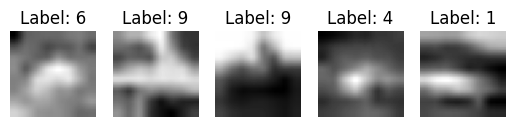

In [39]:
def show_images_in_line(images, labels):
    fig, axes = plt.subplots(1, len(images))
    for idx, (image, label) in enumerate(zip(images, labels)):
        axes[idx].imshow(image.numpy()[0], cmap='gray')
        axes[idx].set_title(f'Label: {label}')
        axes[idx].axis('off')
    plt.show()

# Display a few sample images in a line
images, labels = zip(*(dataset_small[i] for i in range(5)))
show_images_in_line(images, labels)

## Loading config with DDGAN base parameters

In [9]:
parser = argparse.ArgumentParser('ddgan parameters')
parser.add_argument('--seed', type=int, default=1024,
                    help='seed used for initialization')

parser.add_argument('--plan', type=str, default='ind',
                    help='Init type')

parser.add_argument('--resume', action='store_true',default=False)

parser.add_argument('--image_size', type=int, default=32,
                        help='size of image')
parser.add_argument('--num_channels', type=int, default=3,
                        help='channel of image')
parser.add_argument('--centered', action='store_false', default=True,
                        help='-1,1 scale')

parser.add_argument('--posterior', type=str, default='ddpm',
                    help='type of posterior to use')

# ddpm prior
parser.add_argument('--use_geometric', action='store_true',default=False)
parser.add_argument('--beta_min', type=float, default= 0.1,
                        help='beta_min for diffusion')
parser.add_argument('--beta_max', type=float, default=20.,
                        help='beta_max for diffusion')

# brownian bridge prior
parser.add_argument('--epsilon', type=float, default=1.0,
                        help='variance of brownian bridge')

parser.add_argument('--num_channels_dae', type=int, default=128,
                        help='number of initial channels in denosing model')
parser.add_argument('--n_mlp', type=int, default=3,
                        help='number of mlp layers for z')
parser.add_argument('--ch_mult', nargs='+', type=int,
                        help='channel multiplier')
parser.add_argument('--num_res_blocks', type=int, default=2,
                        help='number of resnet blocks per scale')
parser.add_argument('--attn_resolutions', default=(16,),
                        help='resolution of applying attention')
parser.add_argument('--dropout', type=float, default=0.,
                        help='drop-out rate')
parser.add_argument('--resamp_with_conv', action='store_false', default=True,
                        help='always up/down sampling with conv')
parser.add_argument('--conditional', action='store_false', default=True,
                        help='noise conditional')
parser.add_argument('--fir', action='store_false', default=True,
                        help='FIR')
parser.add_argument('--fir_kernel', default=[1, 3, 3, 1],
                        help='FIR kernel')
parser.add_argument('--skip_rescale', action='store_false', default=True,
                        help='skip rescale')
parser.add_argument('--resblock_type', default='biggan',
                        help='tyle of resnet block, choice in biggan and ddpm')
parser.add_argument('--progressive', type=str, default='none', choices=['none', 'output_skip', 'residual'],
                        help='progressive type for output')
parser.add_argument('--progressive_input', type=str, default='residual', choices=['none', 'input_skip', 'residual'],
                    help='progressive type for input')
parser.add_argument('--progressive_combine', type=str, default='sum', choices=['sum', 'cat'],
                    help='progressive combine method.')

parser.add_argument('--embedding_type', type=str, default='positional', choices=['positional', 'fourier'],
                    help='type of time embedding')
parser.add_argument('--fourier_scale', type=float, default=16.,
                        help='scale of fourier transform')
parser.add_argument('--not_use_tanh', action='store_true',default=False)

#geenrator and training
parser.add_argument('--exp', default='experiment_cifar_default', help='name of experiment')
parser.add_argument('--dataset', default='cifar10', help='name of dataset')
parser.add_argument('--nz', type=int, default=100)
parser.add_argument('--num_timesteps', type=int, default=4)

parser.add_argument('--z_emb_dim', type=int, default=256)
parser.add_argument('--t_emb_dim', type=int, default=256)
parser.add_argument('--batch_size', type=int, default=128, help='input batch size')
parser.add_argument('--num_epoch', type=int, default=1200)
parser.add_argument('--ngf', type=int, default=64)

parser.add_argument('--lr_g', type=float, default=1.5e-4, help='learning rate g')
parser.add_argument('--lr_d', type=float, default=1e-4, help='learning rate d')
parser.add_argument('--beta1', type=float, default=0.5,
                        help='beta1 for adam')
parser.add_argument('--beta2', type=float, default=0.9,
                        help='beta2 for adam')
parser.add_argument('--no_lr_decay',action='store_true', default=False)

parser.add_argument('--use_ema', action='store_true', default=False,
                        help='use EMA or not')
parser.add_argument('--ema_decay', type=float, default=0.9999, help='decay rate for EMA')

parser.add_argument('--r1_gamma', type=float, default=0.05, help='coef for r1 reg')
parser.add_argument('--lazy_reg', type=int, default=None,
                    help='lazy regulariation.')

parser.add_argument('--save_content', action='store_true',default=False)
parser.add_argument('--save_content_every', type=int, default=50, help='save content for resuming every x epochs')
parser.add_argument('--save_ckpt_every', type=int, default=25, help='save ckpt every x epochs')

###ddp
parser.add_argument('--num_proc_node', type=int, default=1,
                    help='The number of nodes in multi node env.')
parser.add_argument('--num_process_per_node', type=int, default=1,
                    help='number of gpus')
parser.add_argument('--node_rank', type=int, default=0,
                    help='The index of node.')
parser.add_argument('--local_rank', type=int, default=0,
                    help='rank of process in the node')
parser.add_argument('--master_address', type=str, default='127.0.0.1',
                    help='address for master')

cli_params  = f'--plan {plan} --dataset cifar10 --num_timesteps {T} --exp ddgan_colored_mnist --num_channels 3 --num_channels_dae 128 --num_res_blocks 2 --batch_size 64 --num_epoch 1800 --ngf 64 --nz 100 --z_emb_dim 256 --n_mlp 4 --embedding_type positional --r1_gamma 0.02 --lr_d 1.25e-4 --lr_g 1.6e-4 --lazy_reg 15 --num_process_per_node 1 --ch_mult 1 2 2 2 --save_content --posterior brownian_bridge --epsilon {eps}'

args = parser.parse_args(cli_params.split(' '))
print(args.plan)

args.world_size = args.num_proc_node * args.num_process_per_node
size = args.num_process_per_node

# if not args.use_ema:
#     args.ema_decay = 0
    
if ema_decay > 0:
    args.use_ema = True
args.ema_decay = ema_decay


ind


In [10]:

# train(rank=0, gpu=0, args=args)

rank = 0
gpu = 0


In [11]:

from score_sde.models.discriminator import Discriminator_small, Discriminator_large
from score_sde.models.ncsnpp_generator_adagn import NCSNpp

torch.manual_seed(args.seed + rank)
torch.cuda.manual_seed(args.seed + rank)
torch.cuda.manual_seed_all(args.seed + rank)
device = torch.device('cuda:{}'.format(gpu))

batch_size = args.batch_size

nz = args.nz #latent dimension

if args.dataset == 'cifar10':
    dataset_ = CIFAR10('./data', train=True, transform=transforms.Compose([
                    transforms.Resize(32),
                    #transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]), download=True)

    dataset_small_ = CIFAR10('./data', train=True, transform=transforms.Compose([
                    transforms.Resize(8),
                    transforms.Resize(32),
                    #transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]), download=True)


elif args.dataset == 'stackmnist':
    train_transform, valid_transform = _data_transforms_stacked_mnist()
    dataset = StackedMNIST(root='./data', train=True, download=False, transform=train_transform)

elif args.dataset == 'lsun':

    train_transform = transforms.Compose([
                    transforms.Resize(args.image_size),
                    transforms.CenterCrop(args.image_size),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])

    train_data = LSUN(root='/datasets/LSUN/', classes=['church_outdoor_train'], transform=train_transform)
    subset = list(range(0, 120000))
    dataset = torch.utils.data.Subset(train_data, subset)


elif args.dataset == 'celeba_256':
    train_transform = transforms.Compose([
            transforms.Resize(args.image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])
    dataset = LMDBDataset(root='/datasets/celeba-lmdb/', name='celeba', train=True, transform=train_transform)

elif args.dataset == 'paired_colored_mnist':
    # insert my dataset
    dataset = load_paired_colored_mnist()


dataset = load_paired_cifar(dataset_, dataset_small_)
train_sampler = torch.utils.data.distributed.DistributedSampler(dataset,
                                                                num_replicas=args.world_size,
                                                                rank=rank)
data_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=4,
                                           pin_memory=True,
                                           sampler=train_sampler,
                                           drop_last = True)
def inverse_color(dataset_0, dataset_1):
    return dataset_0, -dataset_1

#if args.plan == 'inv_color':
#    prior_dataset = load_prior_paired_colored_mnist(7, 3, inverse_color)
#else:
#    prior_dataset = load_prior_paired_colored_mnist(2, 3)

if args.dataset == 'cifar10':
    prior_dataset = load_paired_cifar(dataset_, dataset_small_, backwards = (args.plan == 'inv_color'))

prior_data_loader = torch.utils.data.DataLoader(prior_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=4,
                                           pin_memory=True,
                                           sampler=train_sampler,
                                           drop_last = True)

netG = NCSNpp(args).to(device)


#ddp
# netG = nn.parallel.DistributedDataParallel(netG, device_ids=[gpu])
# netD = nn.parallel.DistributedDataParallel(netD, device_ids=[gpu])


exp = args.exp
parent_dir = "./saved_info/dd_gan/{}".format(args.dataset)

exp_path = os.path.join(parent_dir,exp)
if rank == 0:
    if not os.path.exists(exp_path):
        os.makedirs(exp_path)
        #copy_source('BMGAN', exp_path)
        shutil.copytree('score_sde/models', os.path.join(exp_path, 'score_sde/models'))


coeff = Diffusion_Coefficients(args, device)

if args.posterior == "brownian_bridge":
    pos_coeff = BrownianPosterior_Coefficients(args, device)
else:
    raise ValueError('ONLY Brownian Bridge posterior')

T = get_time_schedule(args, device)

if args.resume:
    checkpoint_file = os.path.join(exp_path, 'content.pth')
    checkpoint = torch.load(checkpoint_file, map_location=device)
    init_epoch = checkpoint['epoch']
    epoch = init_epoch
    netG.load_state_dict(checkpoint['netG_dict'])
    # load G

    optimizerG.load_state_dict(checkpoint['optimizerG'])
    schedulerG.load_state_dict(checkpoint['schedulerG'])
    # load D
    netD.load_state_dict(checkpoint['netD_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD'])
    schedulerD.load_state_dict(checkpoint['schedulerD'])
    global_step = checkpoint['global_step']
    print("=> loaded checkpoint (epoch {})"
              .format(checkpoint['epoch']))
else:
    global_step, epoch, init_epoch = 0, 0, 0



Files already downloaded and verified
Files already downloaded and verified
NCSNpp, nz = 100, z_emb_dim = 256, num_channels_dae = 128, ch_mult = [1, 2, 2, 2], n_mlp = 4, num_res_blocks = 2, attn_resolutions = (16,)


# Markovian Projection

In [12]:
import math

class BasePrior:
    def __init__(self):
        pass
    
    @torch.no_grad()
    def sample(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()


class WienerPrior(BasePrior):
    def __init__(self, eps: float = 1):
        self.eps = eps

    @torch.no_grad()    
    def sample(self, x: torch.Tensor) -> torch.Tensor:
        return x + math.sqrt(self.eps) * torch.randn_like(x)
    
class CondLoaderSampler():
    def __init__(self, loader, plan='ind', reverse=False):
        self.loader = loader
        self.reverse = reverse
        self.plan = plan
        self.it = iter(self.loader)
        self.brown_prior = WienerPrior(args.epsilon)

        
    def sample(self, size=5):
        assert size <= self.loader.batch_size
        try:
            if self.plan == 'ind' or self.plan == 'inv_color':
                batch_x, batch_y = next(self.it)
            elif self.plan == 'id':
                batch_x, _ = next(self.it)
                batch_y = batch_x
            elif self.plan == 'aid':
                batch_x, _ = next(self.it)
                batch_y = -batch_x
            elif self.plan == 'ind_id':
                batch_x, _ = next(self.it)
                batch_y, _ = next(self.it)
            elif self.plan == 'ipf':
                if self.reverse:
                    _, batch_y = next(self.it)
                    batch_x = self.brown_prior.sample(batch_y)
                    batch_x = (batch_x - batch_x.min(dim=0)) / (batch_x.max(dim=0)- batch_x.min(dim=0))
                else:
                    batch_x, _ = next(self.it)
                    batch_y = self.brown_prior.sample(batch_x)
        except StopIteration:
            self.it = iter(self.loader)
            return self.sample(size)
        except RuntimeError:
            self.it = iter(self.loader)
            return self.sample(size)
        if len(batch_x) < size:
            return self.sample(size)
            
        if self.reverse:
            return batch_x[:size], batch_y[:size]
        
        return batch_y[:size], batch_x[:size]
    
class OTSampler():
    def __init__(self, loader):
        self.loader = loader
        self.ot_plan_sampler = OTPlanSampler('exact')

    def sample(self, size=5):
        x, y = self.loader.sample(size=size)
        return self.ot_plan_sampler.sample_plan(x, y)
        

class XSampler():
    def __init__(self, sampler: CondLoaderSampler):
        self.sampler = sampler
        
    def sample(self, size=5):
        return self.sampler.sample(size)[0]
    
        
class ModelCondSampler:
    def __init__(self, sampler: XSampler, model_sample_fn, ema_g):
        self.model_sample_fn = model_sample_fn
        self.sampler = sampler
        self.ema_g = ema_g
        
    def sample(self, size=5):
        sample_x = self.sampler.sample(size)
        
        with self.ema_g.average_parameters():
            sample_y = self.model_sample_fn(sample_x)
        return sample_x, sample_y

bmgan_sample_fn = lambda y: sample_from_model(pos_coeff, netG_proj, args.num_timesteps, y, T, args, return_trajectory=True)[0]


In [22]:

def log_images(x, x_t_1, fake_samples, x_0_pred_list, sample_traj, postfix='fw'):
    # from x_t_1 to x
    
    sample_img_path = os.path.join(exp_path, save_dir, 'pics', f'sample_discrete_M_{postfix}.png')
    #print("Sizes", x.shape, x_t_1.shape, fake_samples.shape)
    torchvision.utils.save_image(torch.cat([x[:20], x_t_1[:20], fake_samples[:20]], dim=2),
                                 sample_img_path, normalize=True, nrow=20)
    
    sample_traj_path = os.path.join(exp_path, save_dir, 'pics', f'sample_traj_discrete_M_{postfix}.png')

    torchvision.utils.save_image(torch.cat(sample_traj, dim=3)[:12],
                                 sample_traj_path, normalize=True, nrow=1)
    
    sample_x_0_pred_path = os.path.join(exp_path, save_dir, 'pics', f'sample_x_0_pred_discrete_M_{postfix}.png')
    
    torchvision.utils.save_image(torch.cat([x_t_1] + x_0_pred_list +  [x], dim=3)[:12],
                                 sample_x_0_pred_path, normalize=True, nrow=1)

    sample_input_path = os.path.join(exp_path, save_dir, 'pics', f'input_{postfix}.png')
    torchvision.utils.save_image(x_t_1[:16:4], sample_input_path, normalize=True, nrow=1)

    samples_path = os.path.join(exp_path, save_dir, 'pics', f'samples_{postfix}.png')
    torchvision.utils.save_image(fake_samples[:16], samples_path, normalize=True, nrow=4)
    
    if wandb.run:
        wandb.log({f"Sample_{postfix}": wandb.Image(sample_img_path)})
        wandb.log({f"Sample_traj_{postfix}": wandb.Image(sample_traj_path)})
        wandb.log({f"Sample_x0_pred_{postfix}": wandb.Image(sample_x_0_pred_path)})
        wandb.log({f"Input {postfix}": wandb.Image(sample_input_path)})
        wandb.log({f"Samples {postfix}": wandb.Image(samples_path)})

    
def calculate_transport_cost(x_samples, y_samples):
    return F.mse_loss(x_samples, y_samples)

os.makedirs(os.path.join(exp_path, save_dir))

os.makedirs(os.path.join(exp_path, save_dir, 'pics'))


FileExistsError: [Errno 17] File exists: './saved_info/dd_gan/cifar10/ddgan_colored_mnist/26:10:24_17:29:18eps=1\\T=4\\mini_batch_OT=False\\D_opt_steps=2\\ema_decay=0.99\\ipmf_iters=20\\markovian_proj_iters=10000\\inner_ipmf_mark_proj_iters=5000\\ema_start_ipmf=False\\plan=ind\\'

In [13]:
    
def markovian_projection(max_iter, condsampler, netG_proj, netD_proj,
                         opt_G_proj, opt_D_proj,
                         sch_G_proj, sch_D_proj, ema_g, D_opt_steps=5, fw_or_bw='fw'):
    
    for iteration in range(max_iter):
        if prior:
            condsampler_gt = condsampler
        else:
            if fw_or_bw == 'fw':
                condsampler_gt = CondLoaderSampler(data_loader)
            else:
                condsampler_gt = CondLoaderSampler(data_loader, reverse=True)
        
        if rank == 0 and iteration % 1000 == 0:
            
            x, y = condsampler_gt.sample(args.batch_size)
            x, x_t_1 = x.to(device), y.to(device)
            
            
            fake_sample, x_0_pred_list, trajectory = sample_from_model(pos_coeff, netG_proj, args.num_timesteps, x_t_1, T, args, return_trajectory=True)
            # log to wandb
            
            log_images(x, x_t_1, fake_sample, x_0_pred_list, trajectory, postfix=fw_or_bw)
            
            for i in range(args.num_timesteps+1):
                torchvision.utils.save_image(trajectory[i], os.path.join(exp_path, f"gen_x_{args.num_timesteps-i}_M_{fw_or_bw}_{iteration}.png"), normalize=True)

            trajectory = q_sample_supervised_trajectory(pos_coeff, x, x_t_1)
            for i in range(args.num_timesteps+1):
                torchvision.utils.save_image(trajectory[i], os.path.join(exp_path, f"x_{args.num_timesteps-i}_M_{fw_or_bw}_{iteration}.png.png"), normalize=True)
            
            repeated_samples = torch.cat([pic.unsqueeze(0).repeat([4, 1, 1, 1]) for pic in x_t_1[:10]], dim=0)
            
            fake_sample, x_0_pred_list, trajectory = sample_from_model(pos_coeff, netG_proj,
                                                                       args.num_timesteps, repeated_samples,
                                                                       T, args, return_trajectory=True)
            # log to wandb
            
            log_images(x[:repeated_samples.shape[0]], repeated_samples, fake_sample, x_0_pred_list, trajectory, postfix=fw_or_bw + '_repeated')
        
        
        if rank == 0 and iteration % 1000 == 0:

            with ema_g.average_parameters():

                x, y = condsampler_gt.sample(args.batch_size)

                x, x_t_1 = x.to(device), y.to(device)
                
                fake_sample, x_0_pred_list, trajectory = sample_from_model(pos_coeff, netG_proj, args.num_timesteps, x_t_1, T, args, return_trajectory=True)
                # log to wandb
                
                log_images(x, x_t_1, fake_sample, x_0_pred_list, trajectory, postfix=fw_or_bw + '_ema')
                
                for i in range(args.num_timesteps+1):
                    torchvision.utils.save_image(trajectory[i], os.path.join(exp_path, f"gen_x_{args.num_timesteps-i}_M_{fw_or_bw}_{iteration}_ema.png"), normalize=True)

                trajectory = q_sample_supervised_trajectory(pos_coeff, x, x_t_1)
                for i in range(args.num_timesteps+1):
                    torchvision.utils.save_image(trajectory[i], os.path.join(exp_path, f"x_{args.num_timesteps-i}_M_{fw_or_bw}_{iteration}_ema.png"), normalize=True)
                
                repeated_samples = torch.cat([pic.unsqueeze(0).repeat([4, 1, 1, 1]) for pic in x_t_1[:10]], dim=0)
                
                fake_sample, x_0_pred_list, trajectory = sample_from_model(pos_coeff, netG_proj,
                                                                        args.num_timesteps, repeated_samples,
                                                                        T, args, return_trajectory=True)
                # log to wandb
                
                log_images(x[:repeated_samples.shape[0]], repeated_samples, fake_sample, x_0_pred_list, trajectory, postfix=fw_or_bw + '_repeated' + '_ema')
                
        x, y = condsampler.sample(args.batch_size)
        x, y = x.to(device), y.to(device)
        
        #-----Discriminator Opt Step-----
        
        # Get D ready for optimization
        for p in netD_proj.parameters():  
            p.requires_grad = True  
        
        netD_proj.zero_grad()

        #sample from p(x_0)
        real_data = x.to(device, non_blocking=True)
        input_real_data = y.to(device, non_blocking=True)

        if args.posterior == "ddpm":
            t = torch.randint(0, args.num_timesteps, (1,), device=device).repeat(real_data.size(0))
            x_t, x_tp1 = q_sample_supervised_pairs(pos_coeff, real_data, t, input_real_data)
        elif args.posterior == "brownian_bridge":
            t = torch.randint(0, args.num_timesteps, (real_data.size(0),), device=device)
            x_t, x_tp1 = q_sample_supervised_pairs_brownian(pos_coeff, real_data, t, input_real_data)

        x_t.requires_grad = True

        # train with real
        D_real = netD_proj(x_t, t, x_tp1.detach()).view(-1)

        errD_real = F.softplus(-D_real)
        errD_real = errD_real.mean()

        errD_real.backward(retain_graph=True)

        if args.lazy_reg is None:
            grad_real = torch.autograd.grad(
                        outputs=D_real.sum(), inputs=x_t, create_graph=True
                        )[0]
            grad_penalty = (
                            grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
                            ).mean()


            grad_penalty = args.r1_gamma / 2 * grad_penalty
            grad_penalty.backward()
        else:
            if iteration % args.lazy_reg == 0:
                grad_real = torch.autograd.grad(
                        outputs=D_real.sum(), inputs=x_t, create_graph=True
                        )[0]
                grad_penalty = (
                            grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
                            ).mean()


                grad_penalty = args.r1_gamma / 2 * grad_penalty
                grad_penalty.backward()
        
        # train with fake
        latent_z = torch.randn(batch_size, nz, device=device)

        x_0_predict = netG_proj(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
        
        output = netD_proj(x_pos_sample, t, x_tp1.detach()).view(-1)
        
        errD_fake = F.softplus(output)
        errD_fake = errD_fake.mean()
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        # Update D
        opt_D_proj.step()
        
        
        #-----Generator Opt Step-----
        
        if iteration % D_opt_steps == 0:
        
            # Get G ready for optimization
            for p in netD_proj.parameters():
                p.requires_grad = False
            netG_proj.zero_grad()

            if args.posterior == "brownian_bridge":
                t = torch.randint(0, args.num_timesteps, (real_data.size(0),), device=device)
                x_t, x_tp1 = q_sample_supervised_pairs_brownian(pos_coeff, real_data, t, input_real_data)
            else:
                raise ValueError('ONLY Brownian Bridge posterior')


            latent_z = torch.randn(batch_size, nz,device=device)


            x_0_predict = netG_proj(x_tp1.detach(), t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

            output = netD_proj(x_pos_sample, t, x_tp1.detach()).view(-1)


            errG = F.softplus(-output)
            errG = errG.mean()


            errG.backward()
            opt_G_proj.step()
            ema_g.update()
        
            if wandb.run:
                wandb.log({'LossG': errG.item(), 'LossD': errD.item()})

        if iteration % 100 == 0:
            if rank == 0:
                print('Markovain proj {}: Iter {}, G Loss: {}, D Loss: {}'.format(fw_or_bw, iteration, errG.item(), errD.item()))

#         # SCH iteration step
#         if not args.no_lr_decay and iteration % 1000 == 0:

#             sch_G_proj.step()
#             sch_D_proj.step()

    if rank == 0:
        
        if args.save_content:
            if epoch % args.save_content_every == 0:
                print('Saving content.')
                content = {'epoch': epoch + 1, 'global_step': global_step, 'args': args,
                           'netG_dict': netG_proj.state_dict(), 'optimizerG': opt_G_proj.state_dict(),
                           'netD_dict': netD_proj.state_dict(),
                           'optimizerD': opt_D_proj.state_dict()}
                
                torch.save(content, os.path.join(exp_path, save_dir, f'content_{fw_or_bw}.pth'))


In [14]:

os.environ["WANDB_API_KEY"] = "d819ea0d92a856b5544d1aa919f503250223447c" # Change to your W&B profile if you need it
os.environ["WANDB_MODE"] = "online"
wandb.init(project="BM_GAN_CIFAR", name=exp_name, config=config)


wandb: Currently logged in as: razvor (razvors_team). Use `wandb login --relogin` to force relogin


In [15]:

coloring_seed = 42

"""colored_mnist_2 = load_paired_colored_mnist_one_side(target_number=2, train=False,
                                            seed=coloring_seed, dataset_size=10000)

colored_mnist_3 = load_paired_colored_mnist_one_side(target_number=3, train=False,
                                            seed=coloring_seed, dataset_size=10000)



colored_mnist_2_loader = DataLoader(colored_mnist_2, batch_size=256)
colored_mnist_3_loader = DataLoader(colored_mnist_3, batch_size=256)

true_dataloader_bw = colored_mnist_3_loader

model_input_dataloader_bw = colored_mnist_2_loader

true_dataloader_fw = colored_mnist_2_loader

model_input_dataloader_fw = colored_mnist_3_loader"""

cifar_high = load_paired_cifar(dataset_, dataset_small_, backwards=False, right_zero=True)
cifar_low = load_paired_cifar(dataset_, dataset_small_, backwards=True, right_zero=True)
cifar_high_loader = DataLoader(cifar_high, batch_size=256)
cifar_low_loader = DataLoader(cifar_low, batch_size=256)

true_dataloader_bw = cifar_low_loader
model_input_dataloader_bw = cifar_high_loader

true_dataloader_fw = cifar_high_loader
model_input_dataloader_fw = cifar_low


In [16]:

netG_fw = NCSNpp(args).to(device)

netD_fw = Discriminator_small(nc = 2*args.num_channels, ngf = args.ngf,
                           t_emb_dim = args.t_emb_dim,
                           act=nn.LeakyReLU(0.2)).to(device)

optimizerG_fw = optim.Adam(netG_fw.parameters(),
                           lr=args.lr_g, betas = (args.beta1, args.beta2))
optimizerD_fw = optim.Adam(netD_fw.parameters(),
                           lr=args.lr_d, betas = (args.beta1, args.beta2))

schedulerG_fw = None
schedulerD_fw = None

# schedulerG_fw = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerG_fw, 100, eta_min=1e-5)
# schedulerD_fw = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerD_fw, 100, eta_min=1e-5)

ema_g_fw = ExponentialMovingAverage(netG_fw.parameters(), decay=args.ema_decay)
ema_g_fw.to(device)


NCSNpp, nz = 100, z_emb_dim = 256, num_channels_dae = 128, ch_mult = [1, 2, 2, 2], n_mlp = 4, num_res_blocks = 2, attn_resolutions = (16,)


In [17]:

netG_bw = NCSNpp(args).to(device)

netD_bw = Discriminator_small(nc = 2*args.num_channels, ngf = args.ngf,
                           t_emb_dim = args.t_emb_dim,
                           act=nn.LeakyReLU(0.2)).to(device)

optimizerG_bw = optim.Adam(netG_bw.parameters(),
                           lr=args.lr_g, betas = (args.beta1, args.beta2))
optimizerD_bw = optim.Adam(netD_bw.parameters(),
                           lr=args.lr_d, betas = (args.beta1, args.beta2))

schedulerG_bw = None
schedulerD_bw = None

# schedulerG_bw = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerG_bw, 100, eta_min=1e-5)
# schedulerD_bw = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerD_bw, 100, eta_min=1e-5)

ema_g_bw = ExponentialMovingAverage(netG_bw.parameters(), decay=args.ema_decay)
ema_g_bw.to(device)

#     optimizerG_bw = EMA(optimizerG_fw, ema_decay=args.ema_decay)


NCSNpp, nz = 100, z_emb_dim = 256, num_channels_dae = 128, ch_mult = [1, 2, 2, 2], n_mlp = 4, num_res_blocks = 2, attn_resolutions = (16,)


## ipmf

### First forward iteration

In [23]:
prior = True
condsampler_fw = CondLoaderSampler(prior_data_loader, args.plan)

# if mini_batch_OT:
#     condsampler_fw = OTSampler(condsampler_fw)

markovian_projection(markovian_proj_iters, condsampler_fw, netG_fw, netD_fw,
                         optimizerG_fw, optimizerD_fw,
                         schedulerG_fw, schedulerD_fw, ema_g_fw, D_opt_steps=D_opt_steps, fw_or_bw='fw')

x, y = condsampler_fw.sample(args.batch_size)

x, x_t_1 = x.to(device), y.to(device)

fake_sample, x_0_pred_list, trajectory = sample_from_model(pos_coeff, netG_fw,
                                            args.num_timesteps, x_t_1, T,
                                            args, return_trajectory=True)

log_images(x, x_t_1, fake_sample, x_0_pred_list, trajectory, postfix='fw_after_M')

transport_cost_model = calculate_transport_cost(x_t_1, fake_sample)
transport_cost_ind = calculate_transport_cost(x_t_1, x)

# FID
sample_fn_fw = lambda y: sample_from_model(pos_coeff, netG_fw,
                                            args.num_timesteps, y, T,
                                            args, return_trajectory=True)[0]

fid, ot_cost = compute_fid_and_ot_cost(true_dataloader_fw, model_input_dataloader_fw, sample_fn_fw)

with ema_g_fw.average_parameters():
    
    sample_fn_fw = lambda y: sample_from_model(pos_coeff, netG_fw,
                                                args.num_timesteps, y, T,
                                                args, return_trajectory=True)[0]
    
    fid_ema, ot_cost_ema = compute_fid_and_ot_cost(true_dataloader_fw, model_input_dataloader_fw, sample_fn_fw)

if wandb.run:
    wandb.log({'T_cost_fw': transport_cost_model, 'T_cost_ind': transport_cost_ind,
               'fid_fw': fid, 'fid_fw_ema': fid_ema,
               'ot_cost_fw': ot_cost, 'ot_cost_fw_ema': ot_cost_ema})

torch.save(netG_fw.state_dict(), os.path.join(exp_path, save_dir, f'netG_fw_0.pth'))

with ema_g_fw.average_parameters():
    torch.save(netG_fw.state_dict(), os.path.join(exp_path, save_dir, f'netG_fw_0_ema.pth'))


Markovain proj fw: Iter 0, G Loss: 1.2662832736968994, D Loss: 1.3862919807434082
Markovain proj fw: Iter 100, G Loss: 0.6886044144630432, D Loss: 1.3662716150283813
Markovain proj fw: Iter 200, G Loss: 0.6840886473655701, D Loss: 1.3454103469848633
Markovain proj fw: Iter 300, G Loss: 0.5934921503067017, D Loss: 1.263070821762085
Markovain proj fw: Iter 400, G Loss: 0.7828807830810547, D Loss: 1.4596991539001465
Markovain proj fw: Iter 500, G Loss: 0.030763136222958565, D Loss: 1.2952592372894287
Markovain proj fw: Iter 600, G Loss: 3.3505022525787354, D Loss: 0.9564976096153259
Markovain proj fw: Iter 700, G Loss: 1.0044305324554443, D Loss: 1.129852294921875
Markovain proj fw: Iter 800, G Loss: 2.0430541038513184, D Loss: 1.0183238983154297
Markovain proj fw: Iter 900, G Loss: 3.84625244140625, D Loss: 1.1846885681152344
Markovain proj fw: Iter 1000, G Loss: 1.4573864936828613, D Loss: 2.131495952606201


wandb: Network error resolved after 0:00:21.273091, resuming normal operation.


Markovain proj fw: Iter 1100, G Loss: 0.34288644790649414, D Loss: 1.7889246940612793
Markovain proj fw: Iter 1200, G Loss: 2.588815450668335, D Loss: 2.3500661849975586
Markovain proj fw: Iter 1300, G Loss: 2.496061086654663, D Loss: 1.184662103652954
Markovain proj fw: Iter 1400, G Loss: 1.4631669521331787, D Loss: 0.7916666865348816
Markovain proj fw: Iter 1500, G Loss: 1.8390493392944336, D Loss: 1.5196154117584229
Markovain proj fw: Iter 1600, G Loss: 0.654207706451416, D Loss: 1.2521464824676514
Markovain proj fw: Iter 1700, G Loss: 2.6903843879699707, D Loss: 0.9656921625137329
Markovain proj fw: Iter 1800, G Loss: 2.443289279937744, D Loss: 0.8950133323669434
Markovain proj fw: Iter 1900, G Loss: 3.924802780151367, D Loss: 1.037309169769287
Markovain proj fw: Iter 2000, G Loss: 1.760810136795044, D Loss: 1.112339735031128
Markovain proj fw: Iter 2100, G Loss: 0.38881897926330566, D Loss: 1.3114495277404785
Markovain proj fw: Iter 2200, G Loss: 1.0282578468322754, D Loss: 0.9958

wandb: Network error resolved after 0:00:21.263573, resuming normal operation.


Markovain proj fw: Iter 5100, G Loss: 1.828729510307312, D Loss: 1.081748366355896
Markovain proj fw: Iter 5200, G Loss: 1.9134801626205444, D Loss: 1.2330480813980103
Markovain proj fw: Iter 5300, G Loss: 1.6004056930541992, D Loss: 1.2310948371887207
Markovain proj fw: Iter 5400, G Loss: 0.4820529818534851, D Loss: 1.311396598815918
Markovain proj fw: Iter 5500, G Loss: 1.4785610437393188, D Loss: 1.4339919090270996
Markovain proj fw: Iter 5600, G Loss: 3.760798692703247, D Loss: 1.2865766286849976
Markovain proj fw: Iter 5700, G Loss: 0.6290011405944824, D Loss: 1.3104192018508911
Markovain proj fw: Iter 5800, G Loss: 0.8601955771446228, D Loss: 1.2070295810699463
Markovain proj fw: Iter 5900, G Loss: 2.84024715423584, D Loss: 1.0888649225234985
Markovain proj fw: Iter 6000, G Loss: 1.1679866313934326, D Loss: 1.0152928829193115
Markovain proj fw: Iter 6100, G Loss: 1.4585518836975098, D Loss: 1.368452787399292
Markovain proj fw: Iter 6200, G Loss: 1.263163447380066, D Loss: 1.08265

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
1

### First backward iteration

In [ ]:
prior = True
condsampler_bw = CondLoaderSampler(prior_data_loader, args.plan, reverse=True)

# if mini_batch_OT:
#     condsampler_bw = OTSampler(condsampler_bw)

markovian_projection(markovian_proj_iters, condsampler_bw, netG_bw, netD_bw,
                         optimizerG_bw, optimizerD_bw,
                         schedulerG_bw, schedulerD_bw, ema_g_bw, D_opt_steps=D_opt_steps, fw_or_bw='bw')

x, y = condsampler_bw.sample(args.batch_size)

x, x_t_1 = x.to(device), y.to(device)

fake_sample, x_0_pred_list, trajectory = sample_from_model(pos_coeff, netG_bw,
                                            args.num_timesteps, x_t_1, T,
                                            args, return_trajectory=True)

log_images(x, x_t_1, fake_sample, x_0_pred_list, trajectory, postfix='bw_after_M')

transport_cost_model = calculate_transport_cost(x_t_1, fake_sample)
transport_cost_ind = calculate_transport_cost(x_t_1, x)

# FID
sample_fn_bw = lambda y: sample_from_model(pos_coeff, netG_bw,
                                            args.num_timesteps, y, T,
                                            args, return_trajectory=True)[0]

fid, ot_cost = compute_fid_and_ot_cost(true_dataloader_bw, model_input_dataloader_bw, sample_fn_bw)

with ema_g_bw.average_parameters():

    sample_fn_bw = lambda y: sample_from_model(pos_coeff, netG_bw,
                                                args.num_timesteps, y, T,
                                                args, return_trajectory=True)[0]

    fid_ema, ot_cost_ema = compute_fid_and_ot_cost(true_dataloader_bw, model_input_dataloader_bw, sample_fn_bw)

if wandb.run:
    wandb.log({'T_cost_bw': transport_cost_model, 'T_cost_ind': transport_cost_ind,
               'fid_bw': fid, 'fid_bw_ema': fid_ema,
               'ot_cost_bw': ot_cost, 'ot_cost_bw_ema': ot_cost_ema})


torch.save(netG_bw.state_dict(), os.path.join(exp_path, save_dir, f'netG_bw_0.pth'))

with ema_g_bw.average_parameters():
    torch.save(netG_bw.state_dict(), os.path.join(exp_path, save_dir, f'netG_bw_0_ema.pth'))
    


Markovain proj bw: Iter 0, G Loss: 2.3635683059692383, D Loss: 1.386294960975647
Markovain proj bw: Iter 100, G Loss: 0.06388796865940094, D Loss: 8.358480453491211


wandb: Network error resolved after 0:00:21.267115, resuming normal operation.


Markovain proj bw: Iter 200, G Loss: 0.4097245931625366, D Loss: 1.9333475828170776
Markovain proj bw: Iter 300, G Loss: 0.5921955108642578, D Loss: 1.3164992332458496
Markovain proj bw: Iter 400, G Loss: 1.9560210704803467, D Loss: 1.226304531097412
Markovain proj bw: Iter 500, G Loss: 0.5036044120788574, D Loss: 2.6830246448516846
Markovain proj bw: Iter 600, G Loss: 2.831754207611084, D Loss: 1.022769808769226
Markovain proj bw: Iter 700, G Loss: 0.8861484527587891, D Loss: 1.5655523538589478
Markovain proj bw: Iter 800, G Loss: 0.5505772233009338, D Loss: 1.0583587884902954
Markovain proj bw: Iter 900, G Loss: 1.3480744361877441, D Loss: 1.291761875152588
Markovain proj bw: Iter 1000, G Loss: 17.853199005126953, D Loss: 0.8223460912704468


wandb: Network error resolved after 0:00:21.271616, resuming normal operation.


Markovain proj bw: Iter 1100, G Loss: 2.1338753700256348, D Loss: 1.0437047481536865
Markovain proj bw: Iter 1200, G Loss: 1.4832640886306763, D Loss: 1.251095175743103
Markovain proj bw: Iter 1300, G Loss: 1.9151451587677002, D Loss: 1.4016226530075073
Markovain proj bw: Iter 1400, G Loss: 4.810345649719238, D Loss: 1.077460527420044
Markovain proj bw: Iter 1500, G Loss: 3.1378955841064453, D Loss: 1.0946400165557861
Markovain proj bw: Iter 1600, G Loss: 0.8946588039398193, D Loss: 1.2076842784881592
Markovain proj bw: Iter 1700, G Loss: 0.9291446805000305, D Loss: 0.8743040561676025
Markovain proj bw: Iter 1800, G Loss: 5.619075775146484, D Loss: 1.1255749464035034
Markovain proj bw: Iter 1900, G Loss: 1.3681889772415161, D Loss: 1.2484428882598877
Markovain proj bw: Iter 2000, G Loss: 1.6730186939239502, D Loss: 0.9531487226486206
Markovain proj bw: Iter 2100, G Loss: 1.9149870872497559, D Loss: 1.1009302139282227
Markovain proj bw: Iter 2200, G Loss: 2.0625972747802734, D Loss: 0.4

## Iteration

In [ ]:
prior = False
for i in range(1, ipmf_iters + 1):
    
    # ----Forward model learning (y -> x)----
    
    if ema_start_ipmf:
        with ema_g_fw.average_parameters():
            
            netG_fw_clone = NCSNpp(args).to(device)
            
            netG_fw_clone.load_state_dict(copy.deepcopy(netG_fw.state_dict()))

            netG_fw = netG_fw_clone

            ema_g_fw = ExponentialMovingAverage(netG_fw.parameters(), decay=args.ema_decay)
            
            optimizerG_fw = optim.Adam(netG_fw.parameters(),
                                       lr=args.lr_g, betas = (args.beta1, args.beta2))
    
    bmgan_sample_bw = lambda x: sample_from_model(pos_coeff, netG_bw,
                                                  args.num_timesteps, x.to(device),
                                                  T, args, return_trajectory=True)[0]
    
    sampler_x = XSampler(CondLoaderSampler(data_loader))
    
    condsampler_fw = ModelCondSampler(sampler_x, bmgan_sample_bw, ema_g_bw)

    markovian_projection(inner_ipmf_mark_proj_iters, condsampler_fw, netG_fw, netD_fw,
                             optimizerG_fw, optimizerD_fw,
                             schedulerG_fw, schedulerD_fw, ema_g_fw, D_opt_steps=D_opt_steps, fw_or_bw='fw')

    x, y = condsampler_fw.sample(args.batch_size)

    x, x_t_1 = x.to(device), y.to(device)

    fake_sample, x_0_pred_list, trajectory = sample_from_model(pos_coeff, netG_fw,
                                                args.num_timesteps, x_t_1, T,
                                                args, return_trajectory=True)
    
    log_images(x, x_t_1, fake_sample, x_0_pred_list, trajectory, postfix='fw_after_M')

    transport_cost_model = calculate_transport_cost(x_t_1, fake_sample)
    transport_cost_ind = calculate_transport_cost(x_t_1, x)
    
    # FID
    sample_fn_fw = lambda y: sample_from_model(pos_coeff, netG_fw,
                                                args.num_timesteps, y, T,
                                                args, return_trajectory=True)[0]
    
    fid, ot_cost = compute_fid_and_ot_cost(true_dataloader_fw, model_input_dataloader_fw, sample_fn_fw)
    
    with ema_g_fw.average_parameters():
        
        sample_fn_fw = lambda y: sample_from_model(pos_coeff, netG_fw,
                                                    args.num_timesteps, y, T,
                                                    args, return_trajectory=True)[0]
        
        fid_ema, ot_cost_ema = compute_fid_and_ot_cost(true_dataloader_fw, model_input_dataloader_fw, sample_fn_fw)
    
    if wandb.run:
        wandb.log({'T_cost_fw': transport_cost_model, 'T_cost_ind': transport_cost_ind,
                   'fid_fw': fid, 'fid_fw_ema': fid_ema,
                   'ot_cost_fw': ot_cost, 'ot_cost_fw_ema': ot_cost_ema})
        
    torch.save(netG_fw.state_dict(), os.path.join(exp_path, save_dir, f'netG_fw_{i}.pth'))
    
    with ema_g_fw.average_parameters():
        torch.save(netG_fw.state_dict(), os.path.join(exp_path, save_dir, f'netG_fw_{i}_ema.pth'))
    
    # ----Backward model learning (x -> y)----
    
    if ema_start_ipmf:
        with ema_g_bw.average_parameters():
            
            netG_bw_clone = NCSNpp(args).to(device)
            
            netG_bw_clone.load_state_dict(copy.deepcopy(netG_bw.state_dict()))

            netG_bw = netG_bw_clone
            
            ema_g_bw = ExponentialMovingAverage(netG_bw.parameters(), decay=args.ema_decay)
            
            optimizerG_bw = optim.Adam(netG_bw.parameters(),
                                       lr=args.lr_g, betas = (args.beta1, args.beta2))
    
    bmgan_sample_fw = lambda x: sample_from_model(pos_coeff, netG_fw,
                                                  args.num_timesteps, x.to(device),
                                                  T, args, return_trajectory=True)[0]
    
    sampler_x = XSampler(CondLoaderSampler(data_loader, reverse=True))
    
    condsampler_bw = ModelCondSampler(sampler_x, bmgan_sample_fw, ema_g_fw)
    
    markovian_projection(inner_ipmf_mark_proj_iters, condsampler_bw, netG_bw, netD_bw,
                             optimizerG_bw, optimizerD_bw,
                             schedulerG_bw, schedulerD_bw, ema_g_bw, D_opt_steps=D_opt_steps, fw_or_bw='bw')
    
    x, y = condsampler_bw.sample(args.batch_size)
    
    x, x_t_1 = x.to(device), y.to(device)
    
    fake_sample, x_0_pred_list, trajectory = sample_from_model(pos_coeff, netG_bw,
                                                args.num_timesteps, x_t_1, T,
                                                args, return_trajectory=True)
       
    log_images(x, x_t_1, fake_sample, x_0_pred_list, trajectory, postfix='bw_after_M')
    
    transport_cost_model = calculate_transport_cost(x_t_1, fake_sample)
    transport_cost_ind = calculate_transport_cost(x_t_1, x)
    
    # FID
    
    sample_fn_bw = lambda y: sample_from_model(pos_coeff, netG_bw,
                                                args.num_timesteps, y, T,
                                                args, return_trajectory=True)[0]
    
    fid, ot_cost = compute_fid_and_ot_cost(true_dataloader_bw, model_input_dataloader_bw, sample_fn_bw)
    
    with ema_g_bw.average_parameters():
    
        sample_fn_bw = lambda y: sample_from_model(pos_coeff, netG_bw,
                                                    args.num_timesteps, y, T,
                                                    args, return_trajectory=True)[0]
    
        fid_ema, ot_cost_ema = compute_fid_and_ot_cost(true_dataloader_bw, model_input_dataloader_bw, sample_fn_bw)

    if wandb.run:
        wandb.log({'T_cost_bw': transport_cost_model, 'T_cost_ind': transport_cost_ind,
                   'fid_bw': fid, 'fid_bw_ema': fid_ema,
                   'ot_cost_bw': ot_cost, 'ot_cost_bw_ema': ot_cost_ema})
        
    
    torch.save(netG_bw.state_dict(), os.path.join(exp_path, save_dir, f'netG_bw_{i}.pth'))
    
    with ema_g_bw.average_parameters():
        torch.save(netG_bw.state_dict(), os.path.join(exp_path, save_dir, f'netG_bw_{i}_ema.pth'))
        


In [37]:
x, y = condsampler_bw.sample(args.batch_size)

x, x_t_1 = x.to(device), y.to(device)

fake_sample, x_0_pred_list, trajectory = sample_from_model(pos_coeff, netG_bw,
                                            args.num_timesteps, x_t_1, T,
                                            args, return_trajectory=True)
   
log_images(x, x_t_1, fake_sample, x_0_pred_list, trajectory, postfix='bw_after_M')